In [2]:
import numpy as np
from scipy.io.wavfile import write
import os
import librosa
import matplotlib.pyplot as plt
import torch
from fastai.vision.all import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import math
import itertools
from pyo import *
import os


WxPython is not found for the current python version.
Pyo will use a minimal GUI toolkit written with Tkinter (if available).
This toolkit has limited functionnalities and is no more
maintained or updated. If you want to use all of pyo's
GUI features, you should install WxPython, available here:
http://www.wxpython.org/



In [3]:
# DEFINICIÓN DE PARÁMETROS

DATASET_DIR = "datasetPrueba"           # Directorio donde se guardará el dataset generado
os.makedirs(DATASET_DIR, exist_ok=True) # Crea el directorio si no existe

# Parámetros de audio
sample_rate = 44100  
duration = 1.0       # Duración de cada muestra

# Lista de frecuencias (en Hz)
frequencies = [220, 330, 440, 550, 660, 770, 880, 990, 1100, 1320] 

# Tipos de ondas que se generarán
wave_types = ["sine", "square", "sawtooth", "triangle", "noise"]

# Función que genera la forma de onda según el tipo, frecuencia y duración
def generate_waveform(wave_type, freq, duration, sample_rate):
    # Vector de tiempo desde 0 hasta duración, con pasos según la frecuencia de muestreo
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

    # Generación de diferentes tipos de onda
    if wave_type == "sine":       
        wave = np.sin(2 * np.pi * freq * t)
    elif wave_type == "square":    
        wave = np.sign(np.sin(2 * np.pi * freq * t))
    elif wave_type == "sawtooth":  
        wave = 2 * (t * freq - np.floor(0.5 + t * freq))
    elif wave_type == "triangle":  
        wave = 2 * np.abs(2 * (t * freq - np.floor(0.5 + t * freq))) - 1
    elif wave_type == "noise":     # Ruido blanco
        wave = np.random.uniform(-1, 1, len(t))
    else:
        # Error si se pasa un tipo de onda no reconocido
        raise ValueError(f"Tipo de onda no reconocido: {wave_type}")

    return wave


In [3]:
# Generación espectrograma para dataset

def wav_to_spectrogram_and_save(signal, sample_rate, output_path):
    stft = librosa.stft(signal)
    spectrogram = np.abs(stft)
    spectrogram_db = librosa.amplitude_to_db(spectrogram)  #lo pasamos a decibelios para poder visualizarlo

    # Crear figura y eje explícitamente para evitar que Jupyter muestre la imagen
    fig, ax = plt.subplots(figsize=(10,4))
    librosa.display.specshow(spectrogram_db, y_axis='log', x_axis='time', sr=sample_rate, cmap='inferno', ax=ax)

    # Quitar ejes y guardar en disco
    ax.axis('off')
    fig.savefig(output_path, bbox_inches='tight', pad_inches=0)

    # Cerrar la figura para evitar salida en el notebook
    plt.close(fig)

    return output_path


MemoryError: Unable to allocate 721. KiB for an array with shape (46170, 2) and data type float64

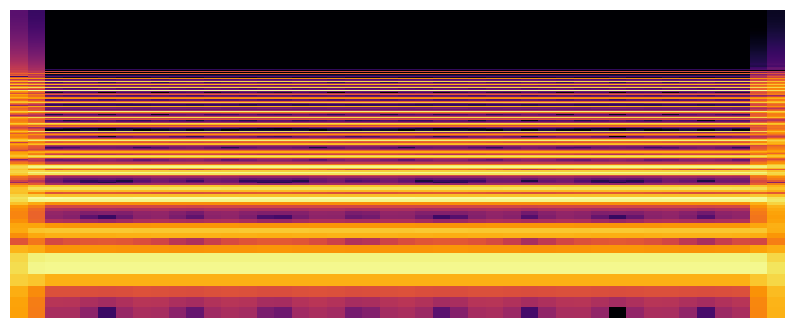

In [4]:
# SINTE FM  
DATASETFM_DIR = "datasetFM"           # Directorio donde se guardará el dataset generado
os.makedirs(DATASETFM_DIR, exist_ok=True) # Crea el directorio si no existe
s = Server(audio="offline",midi="jack",nchnls=1,sr=44100)
s.boot()

# cada clave va desde ini hasta fin con pasos de tamaño step
params = {       # ini fin step
    'carrier'   : (100,2000,100),
    'ratio'     : (0.05,2,0.05),
    'index'     : (1,10,0.5),
    }

vars = locals()
print(vars)

# para hacer variación dinámica de los parámetros los definimos como signals (Sig)
# mapeamos los parámetros a Signal (Sig) para poder variar su valor en tiempo real
for p in params: 
    vars[p] = Sig(params[p][2])


# granulador con los parámetros establecidos asignados a las variables/señal anteriores
synth = FM(
    carrier=carrier,
    ratio=ratio,
    index=index,
    mul=1,  # estos dos los dejamos fijos
    add=0
)
 

synth.ctrl()
synth.out()


# duración de las muestras generadas 
# luego habrá que hacer un trim de la parte inicial para dar tiempo a que la señal
# se estabilice

TIME = 0.5

# lista intensional de valores para un intervalo con un paso
def cover(ini,end,step,steps): 
    return (ini+k*step for k in range(steps))

ranges = []
ext = {}
for p in params:
    ini, end, step = params[p][0], params[p][1], params[p][2]
    steps = int((end-ini)/step)+ 1   
    ranges.append(steps)
    if (ini+steps*step<end):
        print(f"Warning: param {p} does not end")

    # esta lista    
    # ext[p] = [ini+k*step for k in range(steps)]
    # la generamos con llamada a funcion (cover) para que
    # no comparta valores entre variables en las 
    # iteraciones y funcione la evaluacion perezosa        
    ext[p] = cover(ini,end,step,steps)
            
# total de combinaciones
combs = math.prod(ranges)
print(f"Total combinations: {combs}")    


keys = list(ext)    
iter = itertools.product(*map(ext.get, keys))


newVals = dict(zip(keys,iter.__next__()))

for p in params: 
    vars[p].setValue(newVals[p])


out = "file"
#out = "speaker"

sample_rate = 44100

s.recordOptions(dur=TIME, filename='kk', fileformat=0, sampletype=3, quality=0.4)

def generate_fm_signal(carrier, ratio, index, duration=0.5, sr=sample_rate): #sr es la tasa de muestreo
    t = np.linspace(0, duration, int(sr * duration), endpoint=False) #genera un array de tiempos con el momento de cada muestra
    
    # Frecuencia del modulador
    modulator_freq = carrier * ratio
    
    # Síntesis FM
    modulator = index * np.sin(2 * np.pi * modulator_freq * t)
    signal_fm = np.sin(2 * np.pi * carrier * t + modulator) #ecuacion de sintesis FM
    
    return signal_fm

g = 0
def update():    
    global g
    g += 1

    #s.stop()
    newVals = dict(zip(keys,iter.__next__()))
    print(newVals) # aquí tenemos los parámetros iterados, así que los podemos sacar de aquí directamente y utilizarlos para los espectrogramas sin renderizarlos

    print(f'g: {g}')
    for p in params:         
        vars[p].setValue(newVals[p])
        print(p,vars[p].value)
        
    print("\n\n")
    

    signal = generate_fm_signal(
        newVals['carrier'],
        newVals['ratio'],
        newVals['index']
    )
    
    file = os.path.join(DATASETFM_DIR, f"pru_{g}.png")

    img = wav_to_spectrogram_and_save(signal, sample_rate, file)
    
    #s.start()

  
for _ in range(combs):
    try:
        update()
    except StopIteration:
        print("Iterador agotado — todas las combinaciones procesadas.")
        break 
    

#pat2 = Pattern(function=update, time=TIME).play()

#s.start()


In [5]:
# GENERACION DATASET

print("Generando dataset de sonidos...")

for wave in wave_types:
    # Crea un subdirectorio por tipo de onda
    folder = os.path.join(DATASET_DIR, wave)
    os.makedirs(folder, exist_ok=True)

    # Genera un archivo de audio para cada frecuencia
    for freq in frequencies:
        # Genera la onda correspondiente
        signal = generate_waveform(wave, freq, duration, sample_rate)

        # Normaliza la señal en float en rango [-1, 1]
        # NOTA: guardaremos imágenes de espectrograma; la conversión a int16 solo es necesaria si queremos WAV.
        signal = signal / np.max(np.abs(signal))

        # Nombre del archivo PNG (espectrograma)
        filename = os.path.join(folder, f"{wave}_{freq}Hz.png")

        img = wav_to_spectrogram_and_save(signal, sample_rate, filename)

print("Finalizado con éxito!!! Dataset generado en:", os.path.abspath(DATASET_DIR))


Generando dataset de sonidos...
Finalizado con éxito!!! Dataset generado en: c:\Users\angel\Documents\Universidad 4\TFG sin Git\datasetPrueba


In [6]:
# INSPECCIÓN RÁPIDA DEL DATASET 

from collections import OrderedDict

counts = OrderedDict()
for wave_type in sorted(os.listdir(DATASET_DIR)):
    folder = os.path.join(DATASET_DIR, wave_type)
    if not os.path.isdir(folder):
        continue
    imgs = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    counts[wave_type] = len(imgs)

print('Resumen de imágenes por clase:')
for k,v in counts.items():
    print(f" - {k}: {v} imágenes")

total = sum(counts.values())
print(f"Total de imágenes detectadas: {total}")

Resumen de imágenes por clase:
 - noise: 10 imágenes
 - sawtooth: 10 imágenes
 - sine: 10 imágenes
 - square: 10 imágenes
 - triangle: 10 imágenes
Total de imágenes detectadas: 50


In [7]:
# PREPARACIÓN DE DATOS PARA ENTRENAMIENTO (fastai usando imágenes)

print('\nPreparando DataLoaders con fastai usando las imágenes en:', DATASET_DIR)

# fastai espera una estructura de carpetas tipo:
# datasetPrueba/<label>/*.png
path = Path(DATASET_DIR)

# DataBlock para clasificación de imágenes
audio_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224)
)

dls = audio_db.dataloaders(path, bs=8)
print('Número de clases detectadas:', dls.c)



Preparando DataLoaders con fastai usando las imágenes en: datasetPrueba
Número de clases detectadas: 5


In [8]:
# ENTRENAMIENTO con fastai usando un modelo preentrenado (resnet34)

learn = cnn_learner(dls, resnet34, metrics=accuracy)
print('\nEntrenando modelo preentrenado (resnet34) con fastai...')
learn.fine_tune(3)


C:\Users\angel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastai\vision\learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\angel/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:01<00:00, 57.7MB/s]



Entrenando modelo preentrenado (resnet34) con fastai...


epoch,train_loss,valid_loss,accuracy,time
0,2.520310,0.960275,0.500000,00:04


epoch,train_loss,valid_loss,accuracy,time
0,1.248108,0.433710,0.900000,00:06
1,0.866604,0.374935,0.800000,00:06
2,0.679109,0.456605,0.800000,00:06


In [9]:
# EVALUACIÓN

# Creamos la interpretación y validamos
interp = ClassificationInterpretation.from_learner(learn)

# Validación y precisión
val_res = learn.validate()
acc = float(val_res[1]) if len(val_res) > 1 else float(val_res[0])
print(f"\nPrecisión en validación: {acc*100:.2f}%")

# Obtener predicciones del conjunto de validación (ds_idx=1)
res = learn.get_preds(ds_idx=1, with_loss=False)
# get_preds normalmente devuelve (preds, targets)
preds, yv = res

# Pasar a CPU y convertir a numpy
pred_classes = preds.argmax(dim=1).cpu().numpy()
true_classes = yv.cpu().numpy()

print('\nReporte de clasificación (validación):')
target_names = [str(c) for c in dls.vocab]
print(classification_report(true_classes, pred_classes, target_names=target_names))



Precisión en validación: 80.00%



Reporte de clasificación (validación):
              precision    recall  f1-score   support

       noise       1.00      1.00      1.00         2
    sawtooth       0.50      0.50      0.50         2
        sine       1.00      1.00      1.00         2
      square       0.67      0.67      0.67         3
    triangle       1.00      1.00      1.00         1

    accuracy                           0.80        10
   macro avg       0.83      0.83      0.83        10
weighted avg       0.80      0.80      0.80        10




Classification report:
              precision    recall  f1-score   support

       noise       1.00      1.00      1.00         2
    sawtooth       0.50      1.00      0.67         2
        sine       1.00      1.00      1.00         2
      square       1.00      0.33      0.50         3
    triangle       1.00      1.00      1.00         1

    accuracy                           0.80        10
   macro avg       0.90      0.87      0.83        10
weighted avg       0.90      0.80      0.78        10



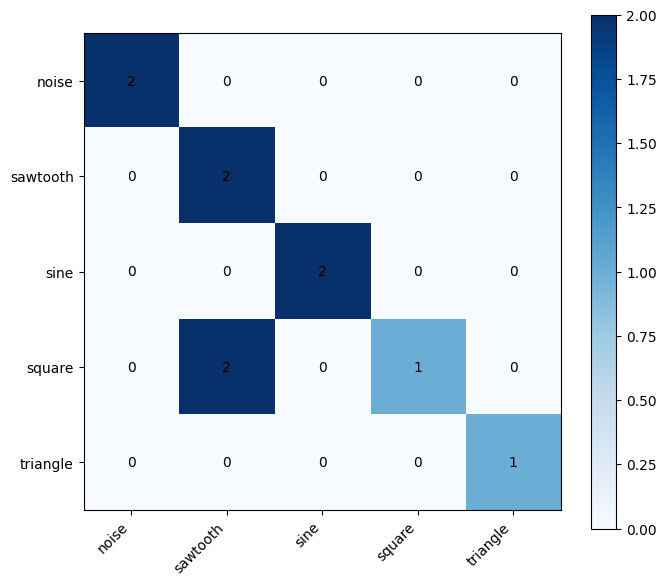


Total mal clasificados: 2


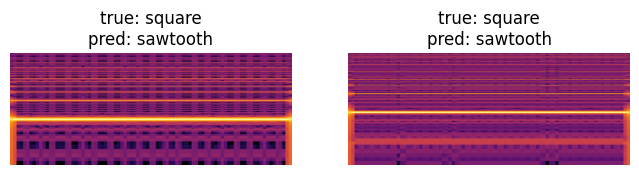

In [ ]:
# DIAGNÓSTICO: matriz de confusión + ejemplos mal clasificados
# PONGO ESTA CELDA PORQUE A VECES PREDICE SAWTOOTH CUANDO ES SQUARE

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

# Obtener predicciones en validación (ds_idx=1)
preds, targs = learn.get_preds(ds_idx=1, with_loss=False)
pred_classes = preds.argmax(dim=1).cpu().numpy()
true_classes = targs.cpu().numpy()

# Informe de clasificación
print('\nClassification report:')
print(classification_report(true_classes, pred_classes, target_names=[str(c) for c in dls.vocab]))

# Matriz de confusión
cm = confusion_matrix(true_classes, pred_classes)
fig, ax = plt.subplots(figsize=(7,6))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(np.arange(len(dls.vocab)))
ax.set_yticks(np.arange(len(dls.vocab)))
ax.set_xticklabels([str(c) for c in dls.vocab], rotation=45, ha='right')
ax.set_yticklabels([str(c) for c in dls.vocab])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# Obtener rutas de validación (asumimos estructura estándar)
try:
    items = dls.datasets[1].items
except Exception:
    items = dls.valid.dataset.items
items = [Path(p) for p in items]

# Mostrar algunos ejemplos mal clasificados (hasta 6)
misidx = np.where(pred_classes != true_classes)[0]
print(f"\nTotal mal clasificados: {len(misidx)}")
N = min(6, len(misidx))
if N > 0:
    fig, axes = plt.subplots(1, N, figsize=(4 * N, 4))
    if N == 1:
        axes = [axes]
    for ax, midx in zip(axes, misidx[:N]):
        imgpath = items[midx]
        img = Image.open(imgpath)
        ax.imshow(img)
        ax.set_title(f"true: {dls.vocab[true_classes[midx]]}\npred: {dls.vocab[pred_classes[midx]]}")
        ax.axis('off')
    plt.show()
else:
    print('No hay ejemplos mal clasificados en validación.')


In [44]:
print("\nProbando con un sonido nuevo")

test_wave = generate_waveform("triangle", 515, duration, sample_rate)
test_signal = test_wave / np.max(np.abs(test_wave))

# Generamos un espectrograma temporal para clasificar
test_img_path = Path('test_triangle.png')
wav_to_spectrogram_and_save(test_signal, sample_rate, test_img_path)

img = PILImage.create(test_img_path)
pred,pred_idx,probs = learn.predict(img)
print(f"El modelo predice que el timbre es: {pred}; prob: {probs[pred_idx]:.4f}")



Probando con un sonido nuevo


El modelo predice que el timbre es: triangle; prob: 0.9896
